In [1]:
from eval import COCOEvalCap
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [2]:
# create coco object and cocoRes object
annFile = 'captions_val2017.json'
resFile = './results/captions_val2017_res.json'
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!


In [3]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

In [4]:
# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 47662, 'reflen': 47449, 'guess': [47662, 42662, 37662, 32662], 'correct': [34803, 18274, 8493, 3899]}
ratio: 1.0044890303272778
Bleu_1: 0.730
Bleu_2: 0.559
Bleu_3: 0.413
Bleu_4: 0.303
computing METEOR score...
METEOR: 0.251
computing Rouge score...
ROUGE_L: 0.535
computing CIDEr score...
CIDEr: 0.975
computing SPICE score...
SPICE: 0.182


In [5]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.730
Bleu_2: 0.559
Bleu_3: 0.413
Bleu_4: 0.303
METEOR: 0.251
ROUGE_L: 0.535
CIDEr: 0.975
SPICE: 0.182


In [6]:
import cv2

# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<30]
print('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

ground truth captions
A man is in a kitchen making pizzas.
Man in apron standing on front of oven with pans and bakeware
A baker is working in the kitchen rolling dough.
A person standing by a stove in a kitchen.
A table with pies being made and a person standing near a wall with pots and pans hanging on the wall.


generated caption (CIDEr score 0.6)
a man standing in a kitchen preparing food


### SPICE Evaluation

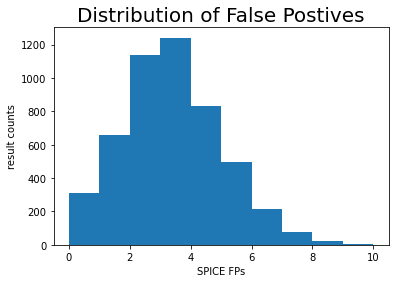

In [152]:
# get FP histogram for SPICE
fp = [eva['SPICE']['All']['fp'] for eva in cocoEval.evalImgs]
plt.hist(fp)
plt.title('Distribution of False Postives', fontsize=20)
plt.xlabel('SPICE FPs', fontsize=10)
plt.ylabel('result counts', fontsize=10)
plt.show()

In [62]:
evals = [eva for eva in cocoEval.evalImgs if eva['SPICE']['All']['fp'] > 6]

In [113]:
print('ground truth captions')
imgId = evals[i]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (SPICE False Positive score %0.1f)'%(evals[i]['SPICE']['All']['fp']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

ground truth captions


generated caption (SPICE False Positive score 7.0)
a train is traveling down the tracks in the country


In [64]:
valFile = 'instances_val2017.json'
coco_inst = COCO(valFile)
catIds = coco_inst.getCatIds(catNms=['person']) # category Id of people subset
imgIds = coco_inst.getImgIds(catIds=catIds) # image Ids containing people category

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [65]:
spice_ppl = [eva for eva in cocoEval.evalImgs if eva['image_id'] in imgIds]

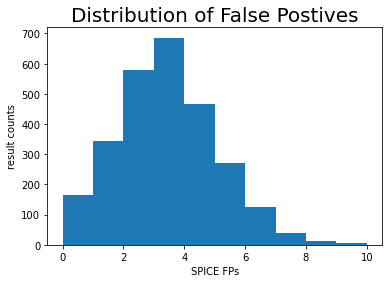

In [154]:
# get only people FP histogram
fp = [eva['SPICE']['All']['fp'] for eva in spice_ppl]
plt.hist(fp)
plt.title('Distribution of False Postives', fontsize=20)
plt.xlabel('SPICE FPs', fontsize=10)
plt.ylabel('result counts', fontsize=10)
plt.show()

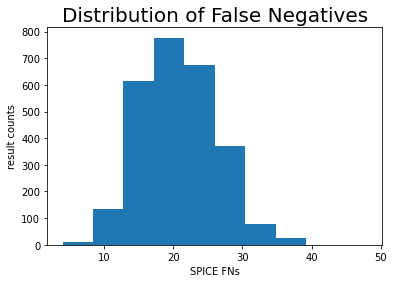

In [145]:
# get only people FP histogram
fn = [eva['SPICE']['All']['fn'] for eva in spice_ppl]
plt.hist(fp)
plt.title('Distribution of False Negatives', fontsize=20)
plt.xlabel('SPICE FNs', fontsize=10)
plt.ylabel('result counts', fontsize=10)
plt.show()

In [60]:
import io, requests, cv2
import numpy as np
import pandas as pd

In [61]:
# instances with SPICE scores above 6 in the people subset
ppl_hi = [eva for eva in spice_ppl if eva['SPICE']['All']['fp'] > 6]
i = 0
imgId = ppl_hi[i]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (SPICE False Positive score %0.1f)'%(ppl_hi[i]['SPICE']['All']['fp']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco_inst.loadImgs(imgId)[0]
img_data = io.BytesIO(requests.get(img['coco_url']).content)
img = cv2.imdecode(np.frombuffer(img_data.read(), np.uint8), 1)[...,::-1]
plt.imshow(img)

NameError: name 'spice_ppl' is not defined

### Looking at annotated images with darker-skinned individuals

In [66]:
imgIds = [82085, 114907, 319534, 377239, 434459,524456, 8532, 57597,73946,319534,336053,385029,426241,532493,549055,213255,319534,344268,377113,
418062,442456,491867]
d_evals = [eva for eva in cocoEval.evalImgs if eva['image_id'] in imgIds]

A man standing in front of a stove cooking.
A man cooking some vegetables on a stovetop
a man standing over a stove wearing an apron  over some pots
a man cooking food on a giant stove 
A gook preparing food on an old gas stove.


generated caption (SPICE False Positive score 2.0)


{'image_id': 57597, 'Bleu_1': 0.8888888886913584, 'Bleu_2': 0.8164965807406125, 'Bleu_3': 0.7249202484964744, 'Bleu_4': 0.596949179054208, 'METEOR': 0.394776492341633, 'ROUGE_L': 0.7858293075684382, 'CIDEr': 1.8959291821547641, 'SPICE': {'All': {'pr': 0.6, 're': 0.11538461538461539, 'f': 0.1935483870967742, 'fn': 23.0, 'numImages': 1.0, 'fp': 2.0, 'tp': 3.0}, 'Relation': {'pr': 0.0, 're': 0.0, 'f': 0.0, 'fn': 10.0, 'numImages': 1.0, 'fp': 2.0, 'tp': 0.0}, 'Cardinality': {'pr': nan, 're': nan, 'f': nan, 'fn': 0.0, 'numImages': 1.0, 'fp': 0.0, 'tp': 0.0}, 'Attribute': {'pr': 0.0, 're': 0.0, 'f': 0.0, 'fn': 6.0, 'numImages': 1.0, 'fp': 0.0, 'tp': 0.0}, 'Size': {'pr': 0.0, 're': 0.0, 'f': 0.0, 'fn': 1.0, 'numIm

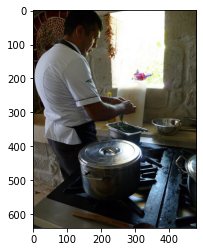

In [131]:
i = 0
imgId = 250990
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (SPICE False Positive score %0.1f)'%(d_evals[i]['SPICE']['All']['fp']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print(d_evals[i])
img = coco_inst.loadImgs(imgId)[0]
img_data = io.BytesIO(requests.get(img['coco_url']).content)
img = cv2.imdecode(np.frombuffer(img_data.read(), np.uint8), 1)[...,::-1]
plt.imshow(img)

In [49]:
# Compute score but skin type
df = pd.read_csv('results_agg.csv')
df = df[df['skin'] != 'Unsure']
df = df.dropna()
df['skin'] = df['skin'].astype(int)
light = df.loc[df['skin'] <= 2]['filename']
dark = df.loc[df['skin'] >= 5]['filename']
mediumSkin = [3,4]
medium = df.loc[df['skin'].isin(mediumSkin)]['filename']

light = light.tolist()
medium = medium.tolist()
dark = dark.tolist()

In [50]:
# Compute score by skin type
li = [eva for eva in cocoEval.evalImgs if int(eva['image_id']) in light]
me = [eva for eva in cocoEval.evalImgs if int(eva['image_id']) in medium]
da = [eva for eva in cocoEval.evalImgs if int(eva['image_id']) in dark]

In [52]:
def compute_average(scores):
    b1 = b2 = b3 = b4 = meteor = rouge = cider = spice = 0.0
    for s in scores:
        b1 += s['Bleu_1']
        b2 += s['Bleu_2']
        b3 += s['Bleu_3']
        b4 += s['Bleu_4']
        meteor += s['METEOR']       
        rouge += s['ROUGE_L']
        cider += s['CIDEr']
        spice += s['SPICE']['All']['f']
    score = np.array([b1, b2, b3, b4, meteor, rouge, cider, spice])
    return score

In [59]:
li_score = compute_average(li) / len(li)
print(li_score)
me_score = compute_average(me) / len(me)
print(me_score)
da_score = compute_average(da) / len(da)
print(da_score)
print(len(li), len(me), len(da))

[0.74947314 0.56532229 0.35171338 0.22145585 0.27333136 0.55067818
 0.95903327 0.19567174]
[0.71639826 0.5141591  0.32748703 0.13497298 0.27225576 0.5328214
 0.88039403 0.16417051]
[0.78980107 0.6544418  0.44967926 0.33264275 0.31865994 0.60662382
 1.02392848 0.14303507]
48 37 14


## Get annotations of ppl images

In [116]:
annFile = 'captions_train2017.json'
coco = COCO(annFile)

loading annotations into memory...
Done (t=1.23s)
creating index...
index created!


In [117]:
valFile = 'instances_train2017.json'
coco_inst = COCO(valFile)
catIds = coco_inst.getCatIds(catNms=['person']) # category Id of people subset
pplIds = coco_inst.getImgIds(catIds=catIds) # image Ids containing people category
annIds = coco.getAnnIds(imgIds=pplIds)

loading annotations into memory...
Done (t=111.70s)
creating index...
index created!


In [120]:
anns = coco.loadAnns(annIds)
print(anns[0])

{'image_id': 262145, 'id': 694, 'caption': 'People shopping in an open market for vegetables.'}


In [129]:
white = []
black = []
asian = []
lat = []
ind = []
off = []
for ann in anns:
    caption = ann['caption'].lower()
    if 'caucasian' in caption or ('white' in caption and 'black and white' not in caption):
        white.append(ann)
    if 'african' in caption or ('black' in caption and 'black and white' not in caption):
        black.append(ann)
    if 'asian' in caption and 'caucasian' not in caption or 'chinese' in caption or 'indian' in caption:
        asian.append(caption)
    if 'latino' in caption or 'latina' in caption or 'hispanic' in caption: 
        lat.append(caption)
    if 'native american' in caption or 'indigenous' in caption or 'native' in caption:
        ind.append(caption)
    if 'off' in caption:
        off.append(ann)

In [130]:
print(off)

[{'image_id': 250990, 'id': 705968, 'caption': 'A gook preparing food on an old gas stove.'}]


In [38]:
import pandas as pd
black_caption = []
for index, b in enumerate(black):
    black_caption.append(b['caption'])
    if index > 5220:
        print(b)
    
dictionary = {'caption': black_caption}   
df = pd.DataFrame(dictionary)
df.to_csv('blackCaption.csv')

{'image_id': 520427, 'id': 762536, 'caption': 'Bicycle rider in black and orange outfit standing next to his bicycle. '}
{'image_id': 258311, 'id': 276097, 'caption': 'A black and grey train passing by building and cars.'}
{'image_id': 258322, 'id': 203156, 'caption': 'Black man shows off old school gray cell phone'}
{'image_id': 127407, 'id': 634895, 'caption': 'A black cat and a person in the background using a computer.'}
{'image_id': 127407, 'id': 640220, 'caption': 'A black cat sits next to a person at a computer desk.'}
{'image_id': 127407, 'id': 643781, 'caption': 'A black cat sitting on a floor next to a guy at a desk.'}
{'image_id': 258559, 'id': 748228, 'caption': 'A purple motorcycle behind a black car at a stoplight. '}
{'image_id': 258571, 'id': 386663, 'caption': "The white devil slavemaster puts a bat in the young black girl's hands and trains her to attack Mexicans on sight."}
{'image_id': 127516, 'id': 362393, 'caption': 'A woman in black wetsuit on a blue and white bo

In [50]:
white_caption = []
for index, w in enumerate(white):
    white_caption.append(w['caption'])
    
dictionary = {'caption': white_caption}   
df = pd.DataFrame(dictionary)
df.to_csv('whiteCaption.csv')

In [53]:
asian_caption = []
for index, a in enumerate(asian):
    asian_caption.append(a)
    
dictionary = {'caption': asian_caption}   
df = pd.DataFrame(dictionary)
df.to_csv('asianCaption.csv')

In [66]:
print(lat)

['a horse dressed in traditional mexican garb standing in front of a hispanic decor background.', 'a hispanic man in a uniform riding a horse.', 'a group of three latino women examine some bananas.', 'a latino man riding a red motorcycle down a street.', 'hispanic people in sombreros walking and riding a horse', 'a very heavy, latina woman smiling and eating food.']


In [61]:
print(len(ind))

['a indigenous woman walking alone with an umbrella', 'native adult with hat kneeling outside of building. ', 'adults interacting with native elephants near river on sunny day.\n', 'man in native clothing looking at display of electronic equipment.', 'a row of elephants with natives standing on their backs.', 'native adult sitting on ledge with fruit on display.', 'people in native dress, stop an inspect a bicycle.', 'adult elephant with large carrier walking on roadway in native land.', 'a young native girl is smiling for a photo. ', 'a native american standing next to a saddled horse.', 'two native americans and their horses stand outside a pueblo.', 'the leanness of the horses and barren landscape shows the poverty native americans live in.', 'grilled kielbasa and onions make a tastier alternative.', 'underweight oxen pulling cart in heavy traffic in native land.', 'adult natives and tourists watching elephants walking on roadway.', 'a small native boy standing in dirt in front of a